# Titanic Survival Classification

With the Titanic dataset, I will continue to advance my skills in data visualization and exploratory data analysis, but through the Seaborn library, to create beautiful and informative plots that are a step beyond what I have previously done. Morever, advanced cleaning and preprocessing techniques, and a thorough understand of the kNN and Decision tree algorithms with manual implementations will provide a strong foundation for future projects. This will be my first experience dealing with missing data and categorical features.

**Main Objectives and Tasks:**
- <u>Import the data</u>
- <u>Train/Validation/Test split</u>
- <u>Cleaning the data</u>
- Exploratory Data Analysis (EDA) using Seaborn
- <u>Preprocess the data</u>
- <u>Build Decision Tree and kNN models.</u>
- <u>Training and Hyperparameter tuning. Use GridSearchCV and RandomizedSearchCV.</u>
- Plot the Decision Tree.
- <u>Plot accuracy curves for hyperparameter values.</u>
- <u>Evaluate on the test set.</u> Use classification report and all metrics. ROC and AUC.


**Extra:**
- <u>Implement KNN model from scratch</u>
- Implement Decision Tree from scratch
- For CV, calculate 95% CI with np.quantile
- Pipeline everything

## Import the Data

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Titanic-Dataset.csv")

## Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=42, stratify=y)

In [896]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Cleaning

In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is a binary classification task whose objective is to predict whether a passenger survived (1) or did not (0), so the 'Survived' column is the target and the rest of the columns are the features.

Moreover, in the dataset we can notice that there are three categorical features, 'Sex', 'Embarked, and 'Pclass'. From these features, 'Embarked' indicates the port the passenger embarked on, and 'Pclass' the type of ticket they purchased (1st, 2nd, or 3rd class). These can be one-hot encoded as dummy variables. Moreover, Cabin appears to contain a lot of missing values, which might require some form of imputation or dropping columns. Before deciding this, it's important to see how many missing values each column has. 

Lastly, the 'Cabin' section contains the deck level indicated by the level and the number referring to the cabin number. Deck level has the potential to be a great indicator of the survival chances of the passengers, and often reflected socioeconomic status.

In [10]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          575 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        160 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


Most columns around 0-2 values, and yet 'Age' is missing 137 entries and 'Cabin' an astonishing 552 entries. Neither of these predictors can be discarded, as age will likely be an important predictor of survival, especially for infants, young, and elderly passengers, while cabin indicates the level at which the passenger was lodged, and is therefore also important. 

In [13]:
X_train.isna().sum().sort_values()

PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            137
Cabin          552
dtype: int64

To sort out the missing values in the age column, the mean will be used.

In [15]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="mean")
X_train_num = np.round(num_imputer.fit_transform(X_train[['Age']]), 1)
X_test_num = np.round(num_imputer.transform(X_test[['Age']]), 1)

To deal with categorical values that are missing (in Embarked), the mode will be used. Moreover, a new feature will be created, Deck, which extracts the first element from the Cabin column, with missing values filled in with "Missing" as there are way too many missing values. Afterwards, 'Cabin' will be dropped.

In [17]:
# Extracts the first element, while preserving missing values.
X_train['Deck'] = X_train['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else np.nan)
X_test['Deck'] = X_test['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else np.nan)

# Discard the Cabin column
X_train = X_train.drop('Cabin', axis=1)
X_test = X_test.drop('Cabin', axis=1)

In [18]:
# Impute the mode
mode_imputer = SimpleImputer(strategy="most_frequent")

X_train_cat = mode_imputer.fit_transform(X_train[['Embarked']])
X_test_cat = mode_imputer.transform(X_test[['Embarked']])

In [19]:
# Drop the former columns
X_train = X_train.drop(['Embarked', 'Age'], axis=1)

In [20]:
X_test = X_test.drop(['Embarked', 'Age'], axis=1)

In [21]:
# Replace NaNs with Missing for Deck
X_train = X_train.fillna("Missing")
X_test = X_test.fillna("Missing")

In [22]:
# Add transformed columns
X_train_transformed_features = np.append(X_train_cat, X_train_num, axis=1)
X_test_transformed_features = np.append(X_test_cat, X_test_num, axis=1)

In [23]:
X_train_transformed_df = pd.DataFrame(X_train_transformed_features, columns=["Embarked", "Age"])
X_test_transformed_df = pd.DataFrame(X_test_transformed_features, columns=["Embarked", "Age"])

In [24]:
X_train_new = pd.concat([X_train.reset_index(drop=True), X_train_transformed_df.reset_index(drop=True)], axis=1)
X_test_new = pd.concat([X_test.reset_index(drop=True), X_test_transformed_df.reset_index(drop=True)], axis=1)

In [25]:
X_train_new.isna().sum().sort_values()

PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Deck           0
Embarked       0
Age            0
dtype: int64

In [26]:
X_test_new.isna().sum().sort_values()

PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Deck           0
Embarked       0
Age            0
dtype: int64

The new training and test data have lost all their remaining missing values through imputation. The next step is to discard any columns that are irrelevant to the training process.

In [28]:
X_train_new.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Deck,Embarked,Age
0,693,3,"Lam, Mr. Ali",male,0,0,1601,56.4958,Missing,S,29.8
1,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,0,0,239854,0.0000,Missing,S,29.8
2,528,1,"Farthing, Mr. John",male,0,0,PC 17483,221.7792,C,S,29.8
3,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,0,1,392091,9.3500,Missing,S,18.0
4,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,1,1,C.A. 31921,26.2500,Missing,S,31.0


PassengerId, Name, and Ticket (which stands for the ticket number) can be dropped as they do not contribute to the survival of a passenger.

In [30]:
X_train_cleaned = X_train_new.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
X_test_cleaned = X_test_new.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [31]:
X_train_cleaned.head()

,Pclass,Sex,SibSp,Parch,Fare,Deck,Embarked,Age
0,3,male,0,0,56.4958,Missing,S,29.8
1,2,male,0,0,0.0000,Missing,S,29.8
2,1,male,0,0,221.7792,C,S,29.8
3,3,female,0,1,9.3500,Missing,S,18.0
4,2,female,1,1,26.2500,Missing,S,31.0


## Exploratory Data Analysis 

<Axes: xlabel='Age', ylabel='Count'>

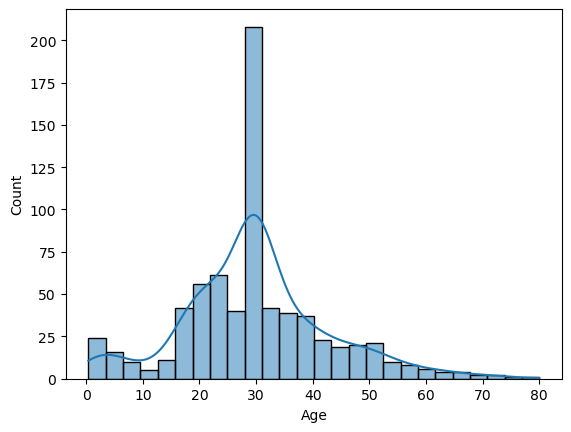

In [33]:
# Plot a histogram to get an idea of the visual distribution of the passengers.
sns.histplot(X_train_cleaned['Age'], kde=True)

The passenger distribution appears to be mostly people aged around 30, which makes sense given the missing data required us to use the mean for imputation, which was 29.8.

<Axes: xlabel='Fare', ylabel='Count'>

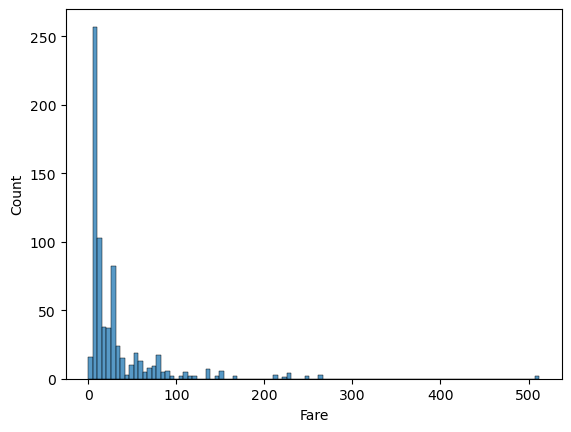

In [35]:
sns.histplot(X_train_cleaned["Fare"])

The ticket fare appears to be overly-skewed, which might be worth adjusting during the data preprocessing step.

In [37]:
# For plotting reasons combining X_train_final and y_train into one df
combined_data = pd.concat([X_train_cleaned.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [38]:
combined_data.head()

,Pclass,Sex,SibSp,Parch,Fare,Deck,Embarked,Age,Survived
0,3,male,0,0,56.4958,Missing,S,29.8,1
1,2,male,0,0,0.0000,Missing,S,29.8,0
2,1,male,0,0,221.7792,C,S,29.8,0
3,3,female,0,1,9.3500,Missing,S,18.0,1
4,2,female,1,1,26.2500,Missing,S,31.0,1


# CATEGORICAL PLOTS

## Data Preprocessing

One-hot encode the categorical variables, scale the numerical ones, and transform any skewed ones.

In [41]:
from sklearn.preprocessing import OneHotEncoder

categorical_feature_names = ["Sex", "Embarked", "Deck"]
ohe = OneHotEncoder(sparse_output=False)
one_hot_encoded_train = ohe.fit_transform(X_train_cleaned[categorical_feature_names])
one_hot_encoded_test = ohe.transform(X_test_cleaned[categorical_feature_names])

In [42]:
ohe_df_train = pd.DataFrame(one_hot_encoded_train, columns=ohe.get_feature_names_out(categorical_feature_names))
ohe_df_test = pd.DataFrame(one_hot_encoded_test, columns=ohe.get_feature_names_out(categorical_feature_names))

In [43]:
# Drop redundant columns
X_train_dropped = X_train_cleaned.drop(categorical_feature_names, axis=1)
X_test_dropped = X_test_cleaned.drop(categorical_feature_names, axis=1)

In [44]:
X_train_ohe = pd.concat([X_train_dropped, ohe_df_train], axis=1)
X_test_ohe = pd.concat([X_test_dropped, ohe_df_test], axis=1)

In [45]:
X_train_ohe.head()

,Pclass,SibSp,Parch,Fare,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T
0,3,0,0,56.4958,29.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,0,0.0000,29.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0,0,221.7792,29.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1,9.3500,18.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,1,1,26.2500,31.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
# Transform the skewed feature, i.e. Fare
X_train_ohe["Fare"] = np.log1p(X_train_ohe["Fare"])
X_test_ohe["Fare"] = np.log1p(X_test_ohe["Fare"])

In [47]:
# Scale the the numerical values (Age, Fare, and Parch, and SibSp)
from sklearn.preprocessing import StandardScaler

numerical_feature_names = ["Age", "Fare", "Parch", "SibSp"]
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(X_train_ohe[numerical_feature_names])
scaled_test = standard_scaler.transform(X_test_ohe[numerical_feature_names])

In [48]:
scaled_df_train = pd.DataFrame(scaled_train, columns=standard_scaler.get_feature_names_out(numerical_feature_names))
scaled_df_test = pd.DataFrame(scaled_test, columns=standard_scaler.get_feature_names_out(numerical_feature_names))

In [49]:
scaled_df_train.head()

,Age,Fare,Parch,SibSp
0,-0.000475,1.124592,-0.466183,-0.465084
1,-0.000475,-3.014278,-0.466183,-0.465084
2,-0.000475,2.508198,-0.466183,-0.465084
3,-0.907751,-0.627019,0.727782,-0.465084
4,0.091790,0.361872,0.727782,0.478335


In [50]:
# Drop unscaled columns
X_train_unscaled_dropped = X_train_ohe.drop(numerical_feature_names, axis=1)
X_test_unscaled_dropped = X_test_ohe.drop(numerical_feature_names, axis=1)

In [51]:
X_train_done = pd.concat([scaled_df_train, X_train_unscaled_dropped], axis=1)
X_test_done = pd.concat([scaled_df_test, X_test_unscaled_dropped], axis=1)

In [52]:
X_train_done.head()

,Age,Fare,Parch,SibSp,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T
0,-0.000475,1.124592,-0.466183,-0.465084,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.000475,-3.014278,-0.466183,-0.465084,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.000475,2.508198,-0.466183,-0.465084,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.907751,-0.627019,0.727782,-0.465084,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.091790,0.361872,0.727782,0.478335,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Building the Models

The models that are going to be used for this binary classification task are a Decision Tree Classifier and a kNN model.

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

kNN = KNeighborsClassifier(n_neighbors=7)
Tree_Classifier = DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_split=2, min_samples_leaf=1, max_features=None,
                                        max_leaf_nodes=None)

## Hyperparameter Tuning

Instead of calling .fit() on the model, a RandomizedSearchCV will go through random parameter combinations of the Decision Tree Classifier on the dataset, while a GridSearchCV will go through the best parameters for the kNN model. The best scores and parameters will be extracted.

In [56]:
# For the cross-validation parameter in GridSearchCV and RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [898]:
# GridSearchCV for kNN
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13]}

grid_search_knn = GridSearchCV(kNN, param_grid=param_grid_knn, cv=kf, scoring="accuracy", error_score="raise")
grid_search_knn.fit(X_train_done, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise', estimator=KNeighborsClassifier(n_neighbors=7),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13]},
             scoring='accuracy')

In [1173]:
grid_search_knn.best_params_

{'n_neighbors': 13}

In [1226]:
grid_search_knn.best_score_*100

81.46296493280857

The best KNN model achieves an accuracy of 81.46% and uses k=13 as its number of neighbors.

In [1236]:
param_grid_decision_tree = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_leaf_nodes": [None, 10, 20, 50, 100],
    "max_features": ['log2', 'sqrt', None],
    "criterion": ["gini", "entropy"]
}

randomized_search_decision_tree = RandomizedSearchCV(Tree_Classifier, param_distributions=param_grid_decision_tree, cv=kf, scoring="accuracy", random_state=42)
randomized_search_decision_tree.fit(X_train_done, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(max_depth=5),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'max_leaf_nodes': [None, 10, 20, 50,
                                                           100],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='accuracy')

In [1238]:
randomized_search_decision_tree.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 20,
 'max_features': None,
 'max_depth': 10,
 'criterion': 'entropy'}

In [1240]:
randomized_search_decision_tree.best_score_*100

81.46119207176542

The best decision tree has an accuracy of 81.46% and the following hyperparameters:
- min_samples_split = 10
- min_samples_leaf = 2
- max_leaf_nodes = 20
- max_features = None
- max_depth = 10
- criterion = entropy

## Evaluation

In [1198]:
# Rebuld KNN model with best parameters from hyperparameter tuning and evaluate their performance
KNN_best = KNeighborsClassifier(n_neighbors=13)
KNN_best.fit(X_train_done, y_train)
scores = KNN_best.score(X_test_done, y_test)

In [1208]:
scores*100

77.6536312849162

In [1243]:
# Do the same for the Decision Tree model
Decision_Tree_best = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=100, max_features=None,
                                            max_depth=10, criterion='entropy')
Decision_Tree_best.fit(X_train_done, y_train)
scores = Decision_Tree_best.score(X_test_done, y_test)

In [1245]:
scores*100

77.09497206703911

The KNN model slightly outperforms the Decision Tree by attaining an accuracy of 77.65% in comparison with the tree-based model's 77.09%.

As a consequence, the final model chosen for this dataset will be the fine-tuned KNN model.

## KNN Implementation

This is a manual implementation of the KNN algorithm, which will include the hyperparameter that determines the amount of neighbors the algorithm should use for the majority vote. For the distance metric, Euclidean Distance and Cosine Similarity will be used.

In [1441]:
class KNN():
    """
    This is a custom implementation of the KNN algorithm. The distance metric and the number of neighbors can both
    be specified.
    
    Parameters:
    - self.n_neighbors is the number of neighbors used in majority voting.
    - self.metric is the distance metric used by the model, either 'euclidean' or 'cosine_similarity'
    - self.X contains the features of the training set.
    - self.y contains the labels of the training set.
 
    """
    def __init__(self, n_neighbors, metric):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = X
        self.y = y
             
    def predict(self, X_new):
        if self.metric == "euclidean":
            # Euclidean distance equation with broadcasting fixes
            o = (np.sum(X_new**2, axis=1).to_frame().values) + (np.sum(self.X**2, axis=1).to_frame()).values.T - 2*X_new@self.X.T
        
            # clip negative values by setting them to 0, then take the square root
            distances = np.sqrt(np.maximum(o, 0))
            
        elif self.metric == "cosine_similarity":
            # Cosine Similarity metric
            o = X_new@self.X.T

            norm_1_squared = np.sqrt(np.sum(X_new**2, axis=1).to_frame().values)
            norm_2_squared = np.sqrt(np.sum(self.X**2, axis=1).to_frame().values)
            denom = np.matmul(norm_1_squared, norm_2_squared.T) 

            # The 1 - cosine similarity is used as higher values in cosine similarity represent more similar values, whereas
            # in finding the k nearest values below, the k smallest values are chosen. So by substracting this value from 1,
            # values that are closer to 0 will be considered more similar.
            distances = 1 - np.divide(o, denom)
            

        # Sort values and take k nearest
        d_sorted = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Flatten structure
        d_flat = (d_sorted).flatten()

        # Replace values with indices
        labels = self.y[d_flat].values.reshape(X_new.shape[0], self.n_neighbors)

        # Get the most common class for each row, and use that as the prediction
        preds = np.array([np.bincount(i).argmax() for i in labels])
        
        return preds

In [1442]:
model = KNN(n_neighbors=1, metric='cosine_similarity')
model.fit(X_train_done, y_train)
preds = model.predict(X_test_done)

In [1444]:
from sklearn.metrics import accuracy_score

k = range(1, 20)
X_train_imp, X_val_imp, y_train_imp, y_val_imp = train_test_split(X_train_done, y_train, train_size=0.75, test_size=0.25, shuffle=True, random_state=42, stratify=y_train)
y_train_imp = y_train_imp.reset_index(drop=True)
y_val_imp = y_val_imp.reset_index(drop=True)

accuracies_euclidean = []
models_euclidean = []

for i in k:
    models_euclidean.append(KNN(n_neighbors=i, metric='euclidean'))
    models_euclidean[i-1].fit(X_train_imp, y_train_imp)
    preds_k = models_euclidean[i-1].predict(X_val_imp)
    accuracy = accuracy_score(y_val_imp, preds_k)
    accuracies_euclidean.append(accuracy)

accuracies_cosine = []
models_cosine = []

for i in k:
    models_cosine.append(KNN(n_neighbors=i, metric='cosine_similarity'))
    models_cosine[i-1].fit(X_train_imp, y_train_imp)
    preds_k = models_cosine[i-1].predict(X_val_imp)
    accuracy = accuracy_score(y_val_imp, preds_k)
    accuracies_cosine.append(accuracy)

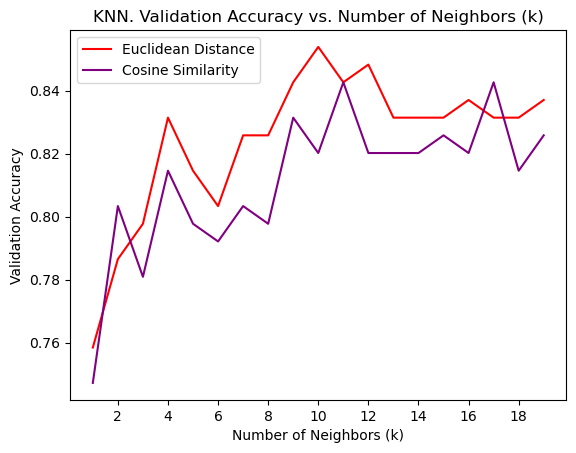

In [1462]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.plot(k, accuracies_euclidean, color="red", label="Euclidean Distance")
plt.plot(k, accuracies_cosine, color="purple", label="Cosine Similarity")
plt.title("KNN. Validation Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.legend()
ax = plt.gca() 
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Based on the graph, the highest validation accuracy occurs when k=9. Moreover, Euclidean Distance seems to outperform Cosine Similarity as a distance metric quite consistently.

In [1403]:
# Get highest and best accuracy models with euclidean and cosine similarity
highest_accuracy_euclidean = np.max(accuracies_euclidean)
highest_accuracy_cosine = np.max(accuracies_cosine)

In [1405]:
highest_accuracy_euclidean*100, highest_accuracy_cosine*100

(85.39325842696628, 85.39325842696628)

In [1411]:
highest_accuracy_k_euclidean = np.argmax(accuracies_euclidean)
highest_accuracy_k_cosine = np.argmax(accuracies_cosine)
highest_accuracy_k_euclidean, highest_accuracy_k_cosine

(9, 9)

The best performing KNN model had a k=9 and attained an validation accuracy of 85.39%, let's evaluate this on the test set.

In [1315]:
best_model_knn = models[9]
best_preds_knn = best_model_knn.predict(X_test_done)
test_accuracy = accuracy_score(y_test, best_preds_knn)
test_accuracy

0.776536312849162

The final test accuracy of the KNN model is 77.65%, which suggests that there may be some degree of overfitting in the model.

## Decision Tree Implementation

TO DO

In [ ]:
class DecisionTree():
    """
    TO DO 

 
    """
    def __init__(self, n_neighbors, metric):
        pass

    def fit(self, X, y):
        pass
             
    def predict(self, X_new):
        pass